In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

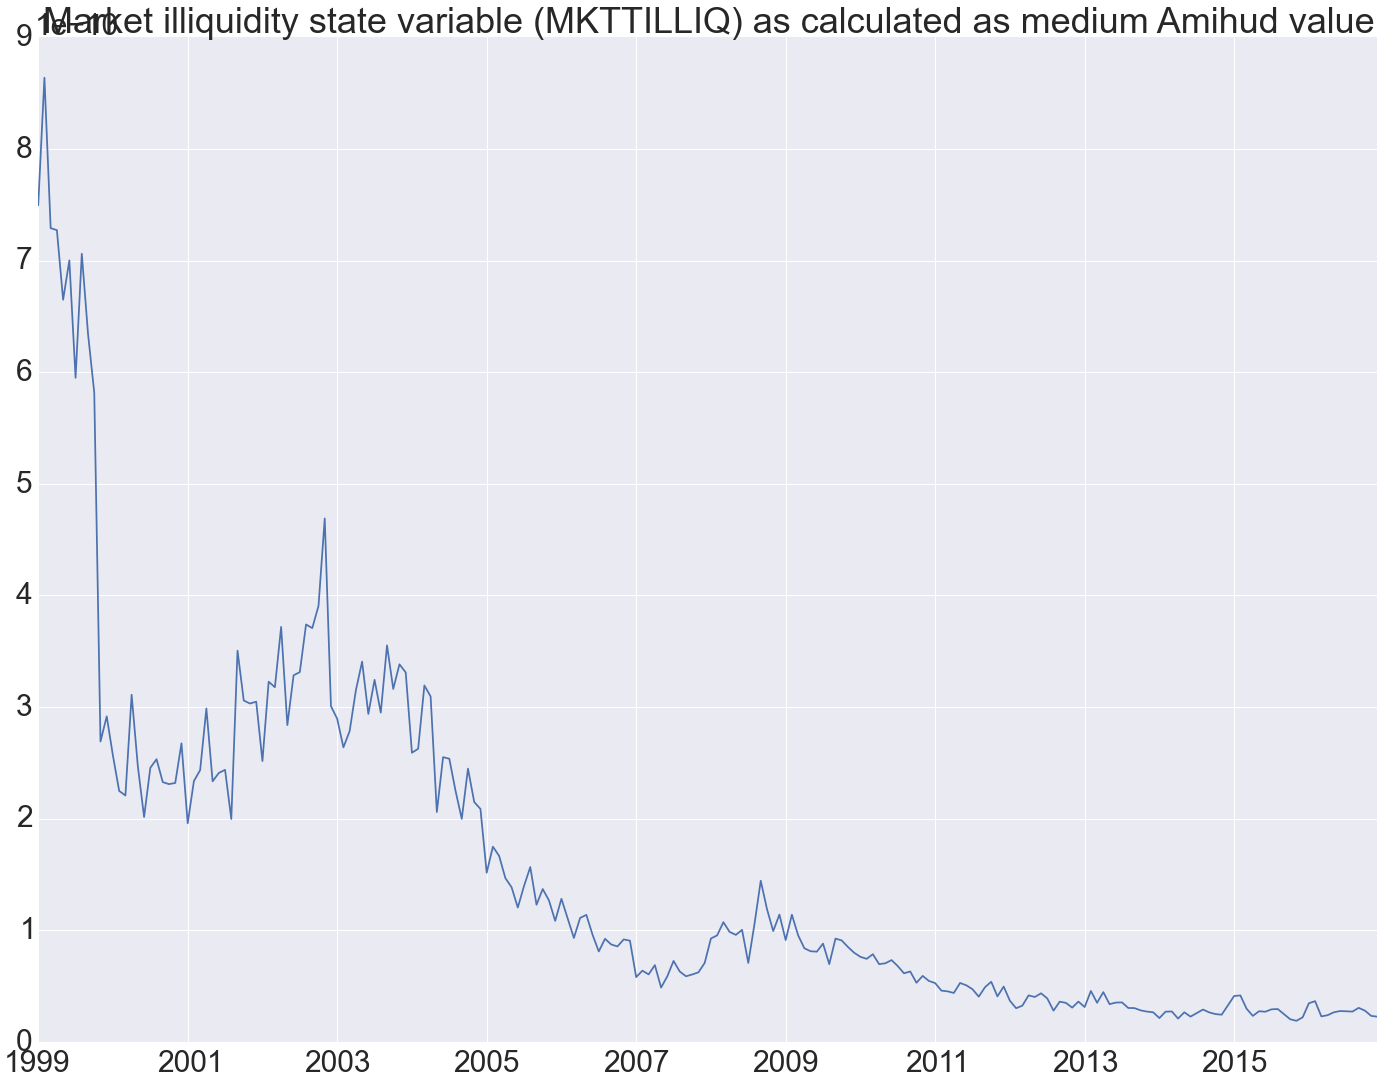

In [5]:
amihud.median(axis=1).dropna().plot(title='Market illiquidity state variable (MKTTILLIQ) as calculated as medium Amihud value')

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


In [6]:
un_dec=quantile_portfolios_annual(amihud,cleansed)

tsmom_model.py:210: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:211: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


Tring scalled performance by volatility to equal but it is a mess.  I think this highlights something is further wrong in the data. 

In [7]:
scalled_rtns=cleansed.resample(rule='m',how='last').pct_change()/pd.ewmstd(cleansed.resample(rule='m',how='last').pct_change(),125,min_periods=60)*.15
scalled_prices=scalled_rtns.cumsum()
sc_dec=quantile_portfolios_annual(amihud,scalled_prices)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=60,adjust=True,com=125).std(bias=False)
  if __name__ == '__main__':


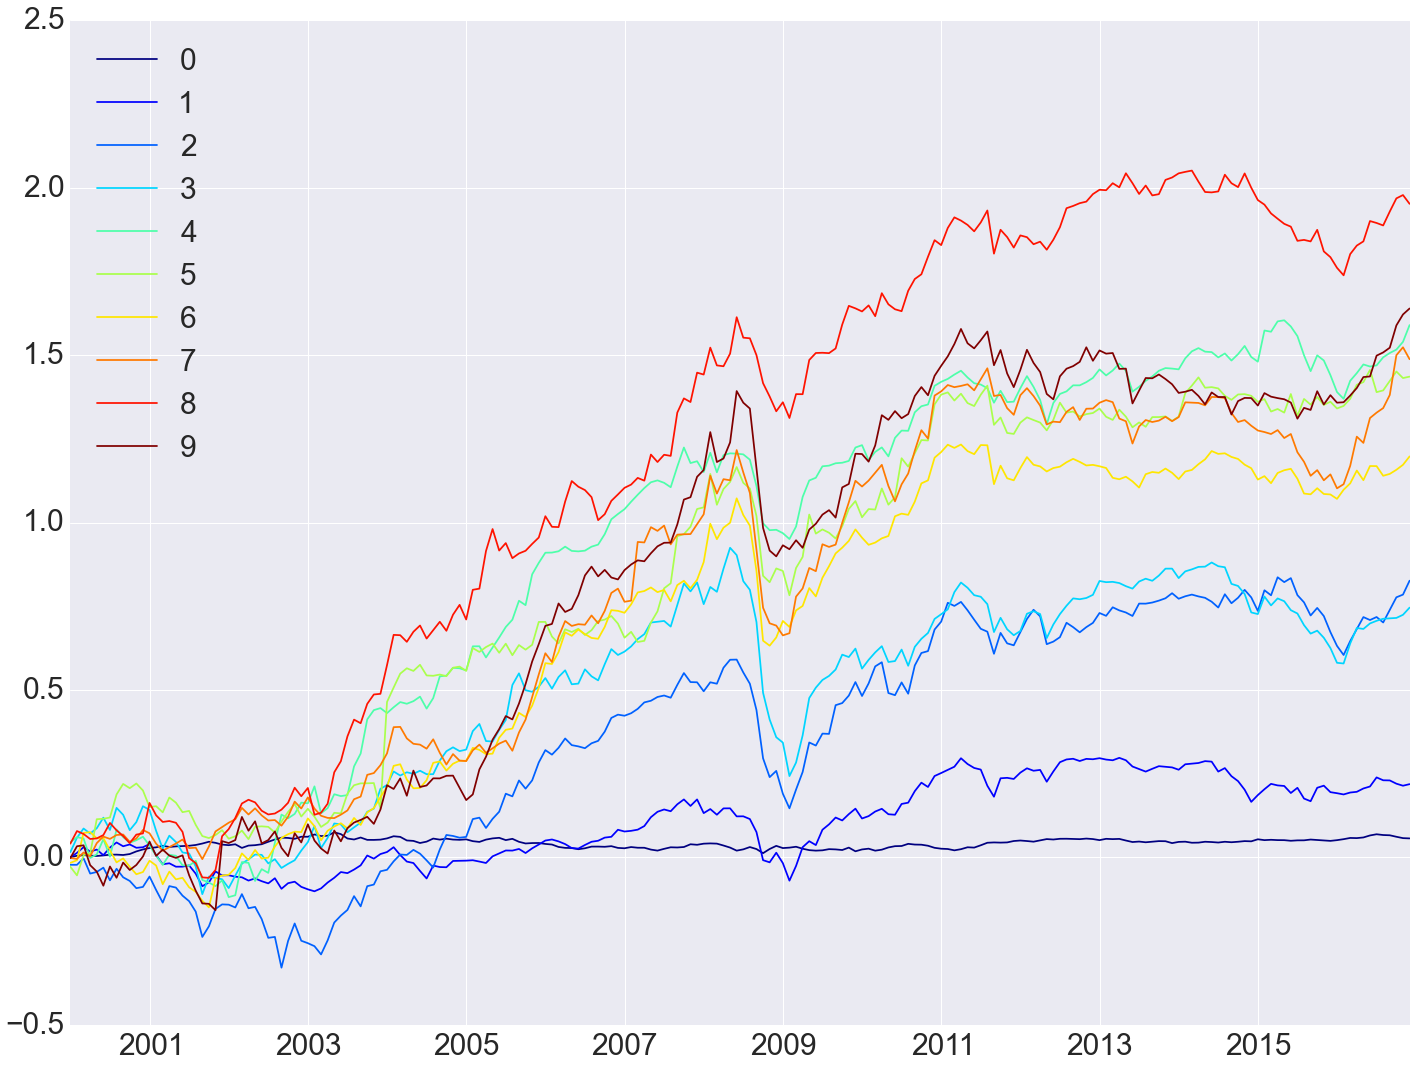

In [8]:
un_dec.dropna().cumsum().plot(colormap='jet')

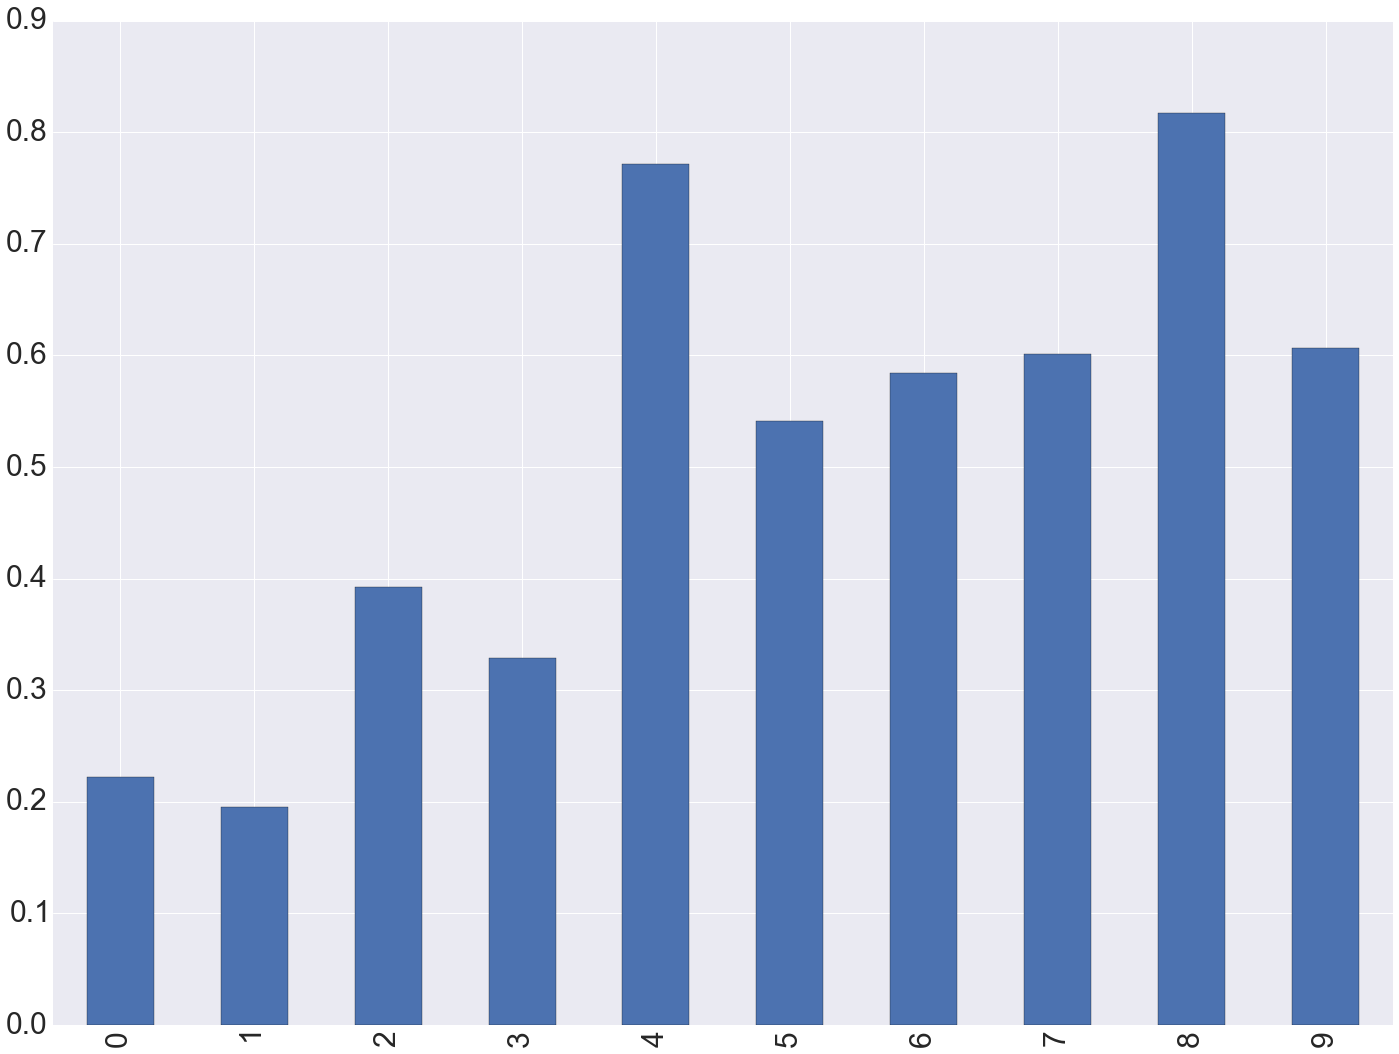

In [36]:
calc_Sharpe(un_dec).plot(kind='bar')

# Table 1 - Summary table
Now run regression of these time series on the overall market liquidity

Then correlation matrix with state variables
* Overall market vol?
* Market illiquidity (median Amihud through time series)
* Transition matrix between groups.
* Perhaps we can add DOWN (dummy variable for when/if the market is down for two years a la Daniel and Moskowitz (2014)
* Market sentiment from one of the other papers
* NBER recessions
* TED spreads

Explination
* Highlight how portfolios were formed.  Equally weighted and formed annually or should we do monthly?
* Mention that this is excess returns (does not include fully funded positions i.e. with cash returns)

# AR(1) analysis: 
* Note I don't use intercept which I think is right

In [122]:
ex=un_dec.dropna(how='all')
en=ex.shift(-1).dropna()
en['Intercept']=1
ex=ex.ix[en.index]
coef=[]
tstat=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(ex[str(i)],en[[str(i)]]).fit()
    coef.append(res.params[str(i)])
    tstat.append(res.tvalues[str(i)])
ar1=pd.DataFrame()
ar1['Coef']=pd.Series(coef,index=ind)
ar1['Tstats']=pd.Series(tstat,index=ind)

In [126]:
res=pd.DataFrame()
res['Monthly Return']=un_dec.mean()*100
res['Standard Deviation']=un_dec.std()*math.sqrt(12)*100
res['Information Ratio']=calc_Sharpe(un_dec)
res['Skewness']=un_dec.skew()
res['Excess Kurtosis']=un_dec.kurtosis()
res['AR(1)']=ar1.Coef
res['AR(1) Tstat']=ar1.Tstats
res =res.round(2)
res['Amihud']='XXX'
res['CAPM Alpha (in %)']='XXX'
res['CAPM Beta (in %)']='XXX'
res.T.round(2)

,0,1,2,3,4,5,6,7,8,9
Monthly Return,0.03,0.11,0.41,0.37,0.78,0.7,0.59,0.73,0.96,0.8
Standard Deviation,1.5,6.6,12.39,13.34,12.12,15.6,12.05,14.56,14.06,15.89
Information Ratio,0.22,0.2,0.39,0.33,0.77,0.54,0.58,0.6,0.82,0.61
Skewness,-0.26,-0.45,-0.48,-1.03,-0,1.48,-1.3,-0.08,0.2,-0.18
Excess Kurtosis,0.43,2.01,1.04,4.46,0.84,12.36,8.07,3.68,0.5,3.46
AR(1),0.04,0.08,0.11,0.23,0.12,-0.05,0.18,0.21,0.06,0.07
AR(1) Tstat,0.6,1.15,1.51,3.31,1.68,-0.74,2.55,3.02,0.87,1.02
Amihud,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Alpha (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Beta (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX


In [127]:
print res.T.to_latex()

\begin{tabular}{lllllllllll}
\toprule
{} &     0 &     1 &      2 &      3 &      4 &      5 &      6 &      7 &      8 &      9 \\
\midrule
Monthly Return     &  0.03 &  0.11 &   0.41 &   0.37 &   0.78 &    0.7 &   0.59 &   0.73 &   0.96 &    0.8 \\
Standard Deviation &   1.5 &   6.6 &  12.39 &  13.34 &  12.12 &   15.6 &  12.05 &  14.56 &  14.06 &  15.89 \\
Information Ratio  &  0.22 &   0.2 &   0.39 &   0.33 &   0.77 &   0.54 &   0.58 &    0.6 &   0.82 &   0.61 \\
Skewness           & -0.26 & -0.45 &  -0.48 &  -1.03 &     -0 &   1.48 &   -1.3 &  -0.08 &    0.2 &  -0.18 \\
Excess Kurtosis    &  0.43 &  2.01 &   1.04 &   4.46 &   0.84 &  12.36 &   8.07 &   3.68 &    0.5 &   3.46 \\
AR(1)              &  0.04 &  0.08 &   0.11 &   0.23 &   0.12 &  -0.05 &   0.18 &   0.21 &   0.06 &   0.07 \\
AR(1) Tstat        &   0.6 &  1.15 &   1.51 &   3.31 &   1.68 &  -0.74 &   2.55 &   3.02 &   0.87 &   1.02 \\
Amihud             &   XXX &   XXX &    XXX &    XXX &    XXX &    XXX &    XXX &    XXX 

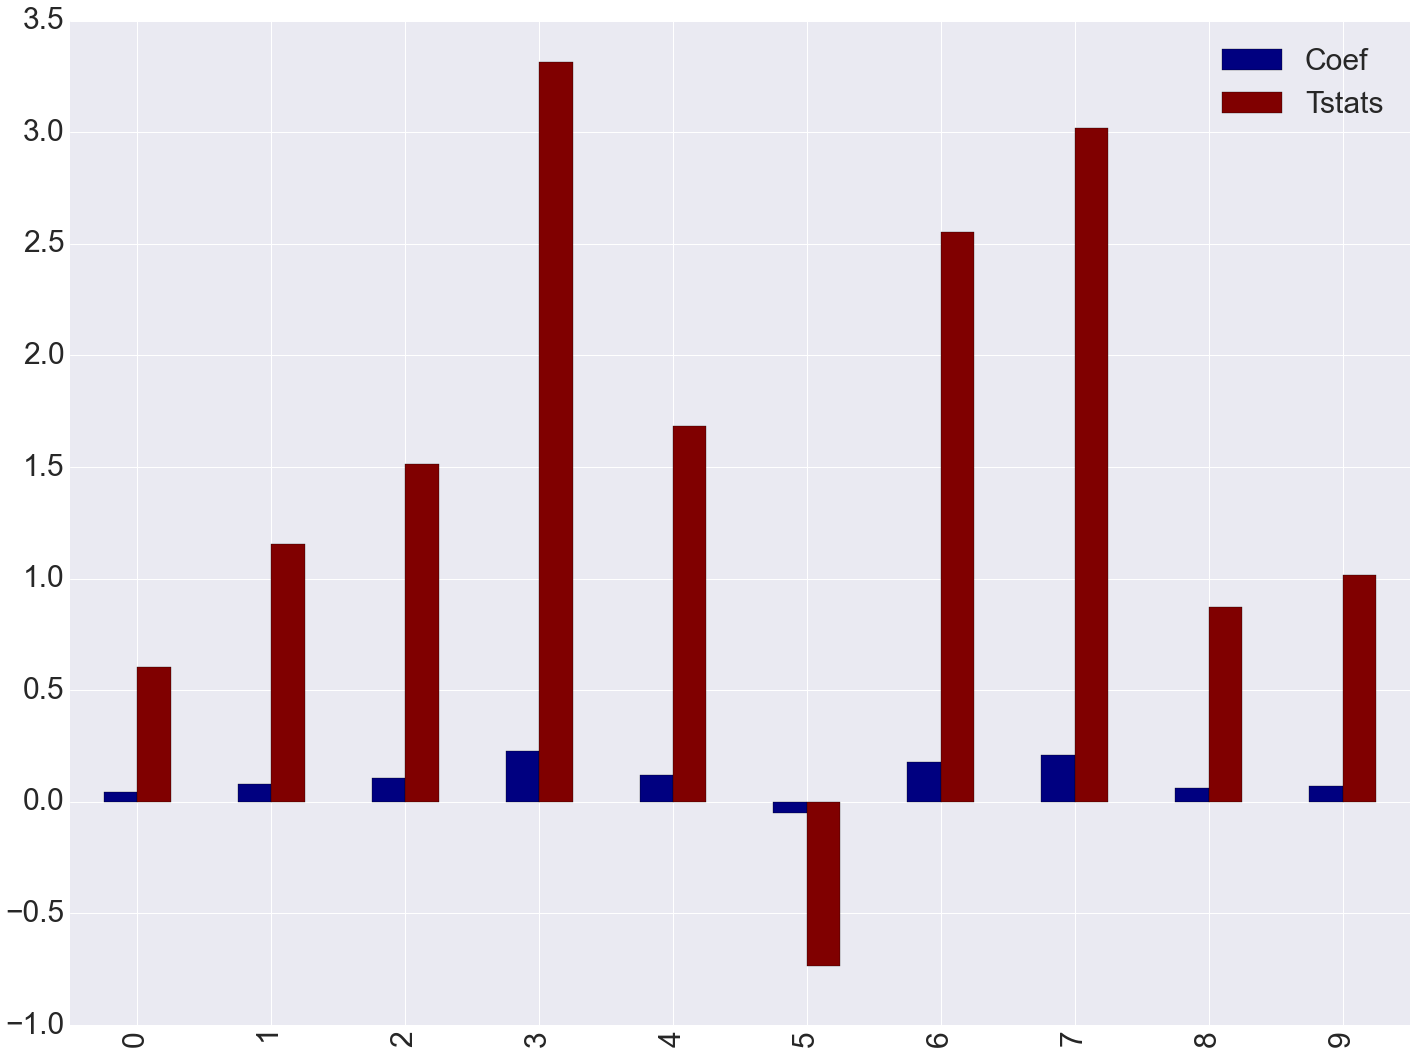

In [104]:
ar1.plot(kind='bar',colormap='jet')

Example regression which you will need to do for CAPM for each decile (but you will need to add intercept)

# Monthly portoflio sorts

In [24]:
monthly_dec=quantile_portfolios_monthly(amihud,cleansed)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [25]:
res=pd.DataFrame()
res['Monthly Return']=monthly_dec.mean()*100
res['Standard Deviation']=monthly_dec.std()*math.sqrt(12)*100
res['Information Ratio']=calc_Sharpe(monthly_dec)
res['Skewness']=monthly_dec.skew()
res['Excess Kurtosis']=monthly_dec.kurtosis()
res['Amihud']='XXX'
res['CAPM Alpha (in %)']='XXX'
res['CAPM Beta (in %)']='XXX'
res['AR(1)']='XXX'
res.T.round(2)

,0,1,2,3,4,5,6,7,8,9
Monthly Return,-0.00777091,0.245271,0.230641,0.660236,0.583885,0.563388,0.619616,0.643899,0.802163,0.763323
Standard Deviation,1.81187,6.13044,12.8193,14.4185,12.568,13.693,10.8641,16.1029,15.0029,17.6808
Sharpe,-0.0514667,0.480105,0.215901,0.549493,0.557499,0.49373,0.684398,0.479837,0.641608,0.51807
Skewness,-0.596048,-0.508842,-0.435812,-0.40717,0.0418923,-0.384923,0.131782,1.53489,0.0410723,-0.473858
Excess Kurtosis,3.87771,1.04204,1.61894,4.01553,0.307745,3.37455,1.84245,13.4999,0.470716,6.16698
Amihud,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Alpha (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Beta (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
AR(1),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX


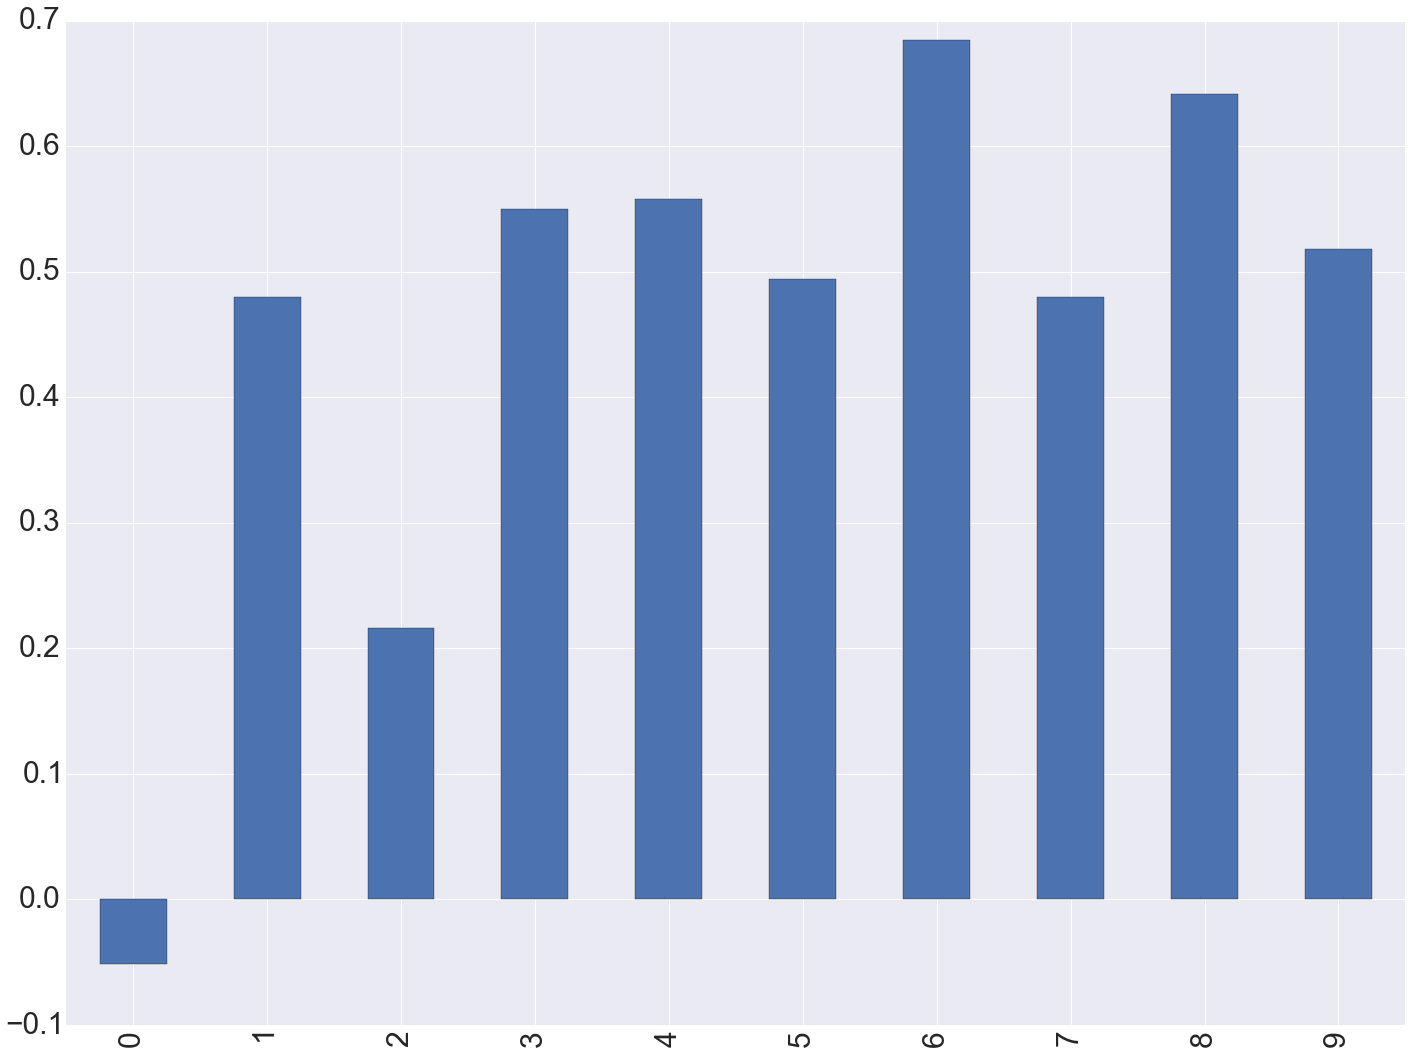

In [27]:
res.Sharpe.plot(kind='bar')

In [29]:
monthly_dec.to_pickle('monthly.pickle')

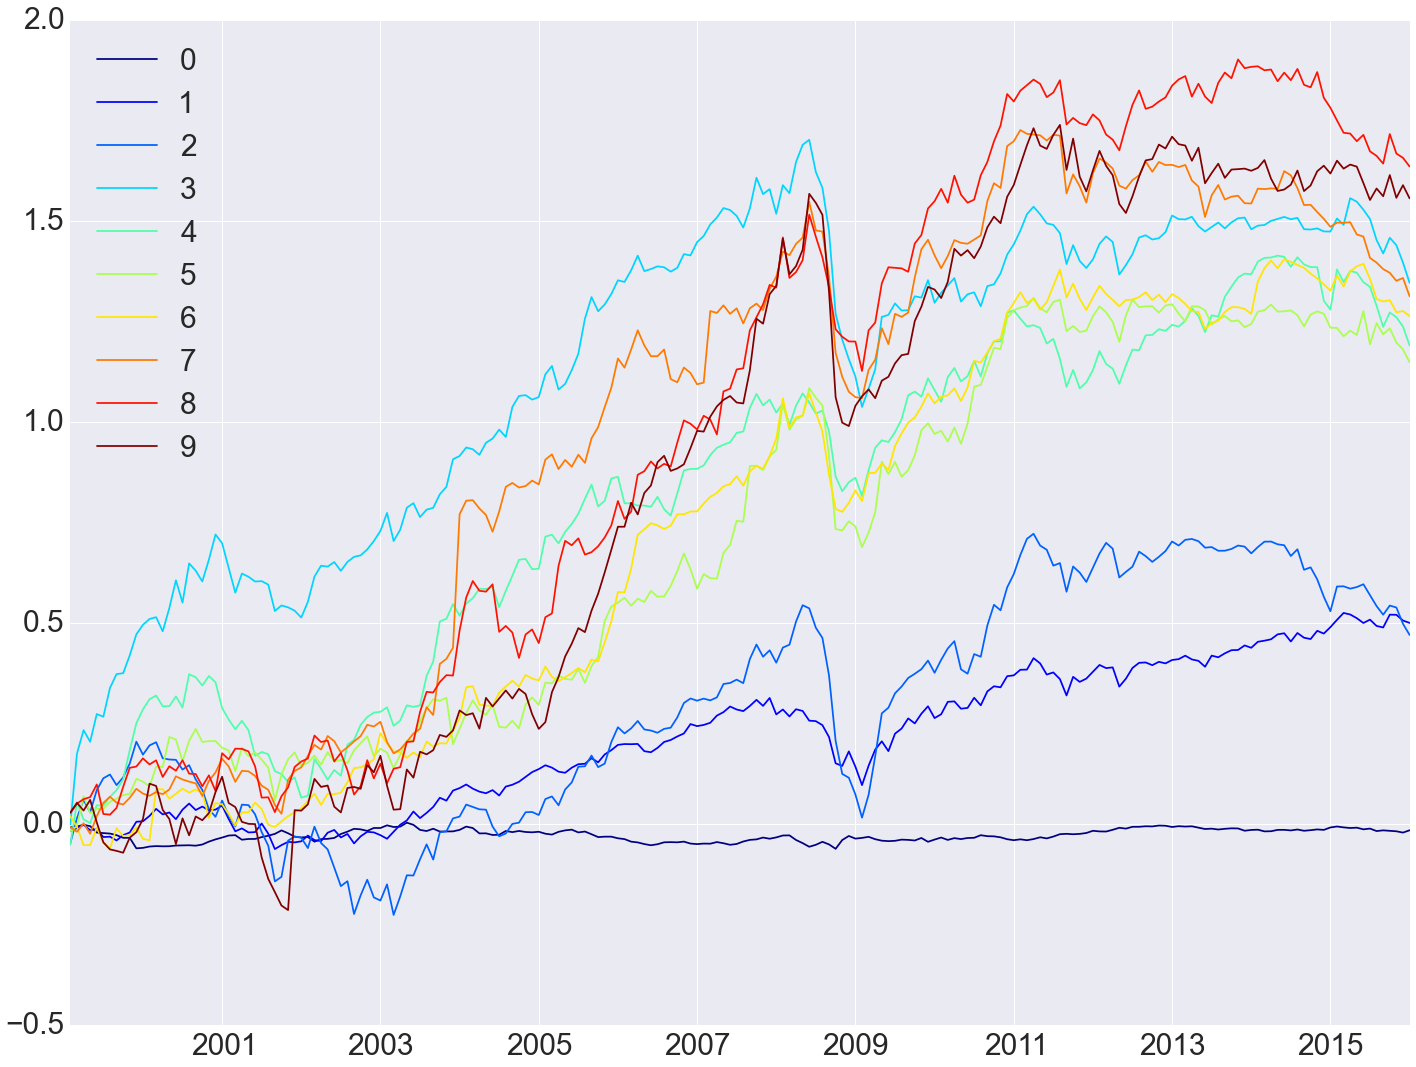

In [33]:
pd.read_pickle('monthly.pickle').dropna().cumsum().plot(colormap='jet')

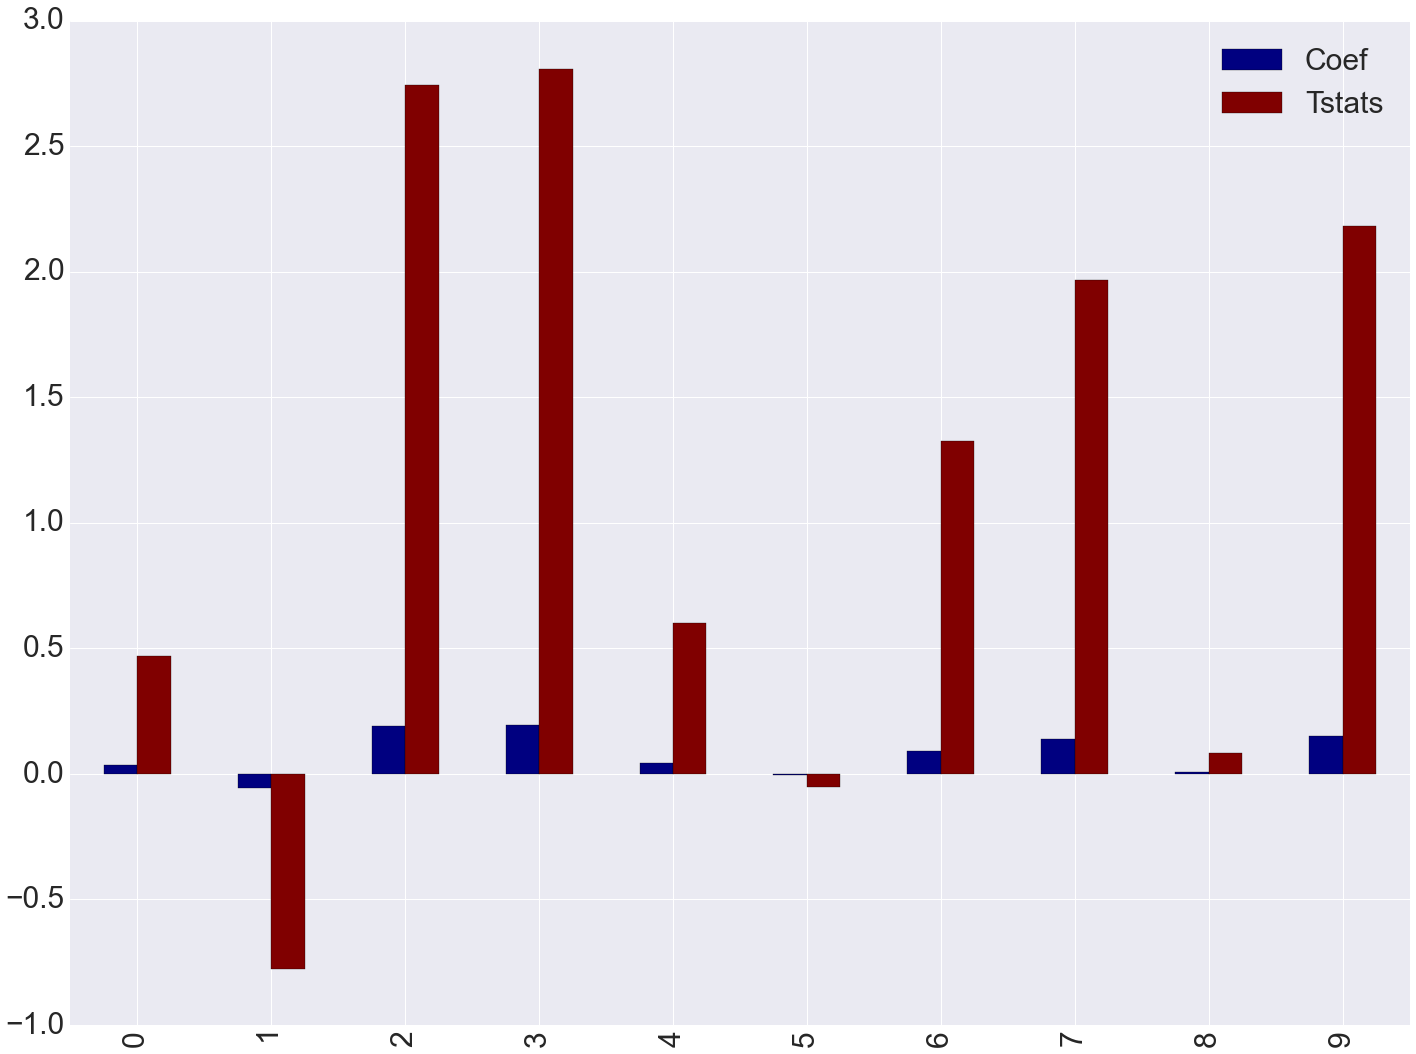

In [128]:
ex=monthly_dec.dropna(how='all')
en=ex.shift(-1).dropna()
en['Intercept']=1
ex=ex.ix[en.index]
coef=[]
tstat=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(ex[str(i)],en[[str(i)]]).fit()
    coef.append(res.params[str(i)])
    tstat.append(res.tvalues[str(i)])
ar1_m=pd.DataFrame()
ar1_m['Coef']=pd.Series(coef,index=ind)
ar1_m['Tstats']=pd.Series(tstat,index=ind)
ar1_m.plot(kind='bar',colormap='jet')